# Project 4. "The Experiment"

## Objectives
In this assignment, we will learn how to
1. use a library of functions (`pymysql`) to interact with a relational database system (`MySQL`) from a high-level language (`Python`) 
1. serialize a complex object (an image) to be stored in a blob field
1. use transactions to ensure integrity of data

---

## Scenario
Three intrepid scientists Alice, Bob, and Carol are embarking on a series of groundbreaking experiments.

### acquire
The three scientists will conduct one experiment per day.  No two experiments can be done on the same date.  At the start the experiment, the  will draw straws to decide who will run the experiment that day.  During each experiment, they will acquire 7 grayscale images of mysterios blobs.  Therefore, during each experiment, they will store the date of the experiment, the name of the person who did the experiment, and the acquired images.

The acquisition of one experiment will be implemented by the function `acquire`.

### analyze
The analysis function `analyze` will check if there exist any images that have not been processed yet.  If there is nothing to analyze, the function returns.  Otherwise, it takes one image, analyzes it, and quits.  During the analysis, the function finds the blobs in the image one at a time, finding their (x,y) positions and amplitudes.  The result must be stored for each blob as they are extracted. Unfortunately, the analysis program will occasionally fail (throw an exception) and quit before finding all the blobs.  The data processing function must ensure that partial results never appear in the database for others to see.

### summary
The `summary` function will print the number of experiments that a given scientist has conducted, the percentage of images that have been analyzed, the average number of blobs per image for that scientist, and the average amplitude of blobs for that scientist.

---

# Submission
You will modify the four functions provided below. 
1. `define(conn, user)` -- to define the database schema.
2. `acquire(conn, date)`  -- to simulate the data acquisition of one experiment.
3. `analyze(conn)` -- to analyze one image (or fail to do so).
4. `summary(conn, scientist)` -- to print the summary of results for one scientist.

After you implement these functions, save this notebook as a Python file named `yourusername.py` and submit it through the Blackboard by 11.59 on Thursday, Nov 17th. 

# Stipulations
1. All data exchange between the four functions should be done through the database.  They should not store information in global variables, local files, etc.
2. All SQL queries should be issued through the functionality provided by the `pymysql` library.  The magic `%sql commands` from previous assignments are not allowed.
3. `analyze` must use transactions to ensure that the data for one image are either populated completely and correctly or not at all. 
---

In [18]:
# Preliminaries:
# This section provides functions that will be used by your project.
import numpy as np
import time
from scipy import ndimage


def make_image(seed=None, ncells=100, size=256):
    """
    make blob image
    """
    np.random.seed(seed)
    im = np.zeros((size, size))
    points = (size*np.random.random((2, ncells))).astype(np.int)
    im[points[0], points[1]]= 1 + 0.1*np.random.normal(size=ncells)
    return ndimage.gaussian_filter(im, sigma=size/(6.*np.sqrt(ncells)))


class BlobFail(Exception):
    pass


def find_blobs(im, fail_rate=0.02, delay=0.1):
    """
    Find peaks a generator of x, y coordinates of blobs
    """
    for y, x in zip(*np.where(im > ndimage.filters.percentile_filter(im, 85, size=3))):
        if np.random.random() < fail_rate:
            raise BlobFail
        time.sleep(delay)
        yield x, y

In [19]:
# Enable inline graphics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


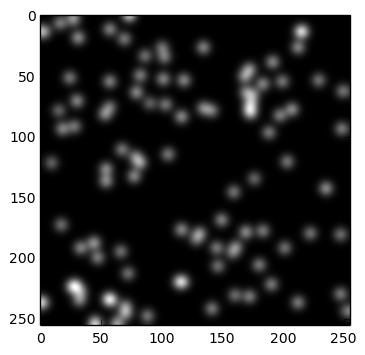

In [20]:
# demonstrate image generation
im = make_image()
plt.imshow(im, cmap='gray');

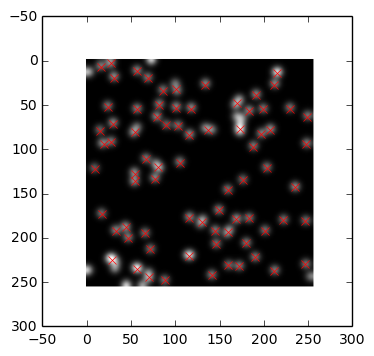

In [21]:
#demonstate blob detection without exceptions or delays
plt.imshow(im, cmap='gray');
for x, y in find_blobs(im, fail_rate=0.0, delay=0):
    plt.plot(x, y,'rx', hold=True)

27 2
16 7
57 12
215 14
31 19
69 20
134 27
212 27
101 32
86 34
191 39
170 48
82 50
24 52
101 53
118 54
229 54
57 55
199 55
183 57
249 63
79 64
30 71
90 73
103 74
173 77
137 78
207 78
15 79
54 80
197 83
116 84
27 92
19 94
248 94
188 97
67 111
105 115
80 120
203 121
9 122
54 128
77 133
176 135
54 136
235 143
159 146
149 169
17 173
116 177
183 178
169 179
222 180
247 181
130 182
44 188
33 192
145 192
201 192
160 193
66 195
47 200
180 206
146 207
72 213
116 220
190 222
29 225
247 230
160 231
Fail


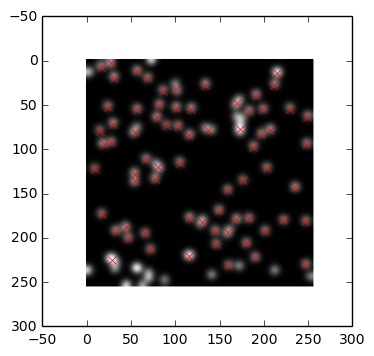

In [22]:
# Demonstrate blob detection with errors and error handling
# This illustrates a realistic acqusition or analysis scenario that may get interrupted. 
plt.imshow(im, cmap='gray');
try:
    for x, y in find_blobs(im):
        print(x, y)
        plt.plot(x, y,'rx', hold=True)
except BlobFail:
    print('Fail')
else:
    print('Success')

In [23]:
# Supply database credentials
import getpass
host = 'db.cs3375.us'
user = 'ahmed'   # change this to your username
password = getpass.getpass()

········


In [24]:
# Connect to the database
import pymysql
conn = pymysql.connect(host=host, user=user, password=password)
cur = conn.cursor()

In [11]:
# Create a demo database
cur.execute("""
CREATE SCHEMA IF NOT EXISTS {user}_demo;
USE {user}_demo;
""".format(user=user));

In [12]:
# This example shows how to store a complex object such an image in the database 
# using object serialization such as pickle.dumps and pickle.loads functions.

#create a table to store images
cur.execute("""
CREATE TABLE IF NOT EXISTS images(
    image_id INT PRIMARY KEY AUTO_INCREMENT, 
    image LONGBLOB,
    s_id int,
    x int NULL,
    y int NULL,
    date date
    )
""");


In [25]:
# save three images in the database 
import pickle
for i in range(3):
    image = make_image()
    serialized_image = pickle.dumps(image)
    cur.execute('INSERT INTO images VALUE (%(i)s, %(image)s)', 
                dict(i=i, image=serialized_image))
    
# more succinctly
for i in range(3,6):
    cur.execute('INSERT INTO images VALUE (%(i)s, %(image)s)', 
            dict(i=i, image=pickle.dumps(make_image())))


InternalError: (1046, 'No database selected')

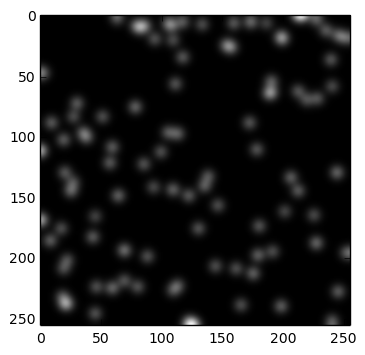

In [14]:
# retrive one image from the database
cur.execute('SELECT image FROM images WHERE image_id=2')
result = cur.fetchone()
plt.imshow(pickle.loads(result[0]), cmap='gray');

In [15]:
# Illustration of cancelled transaction
cur.execute('SELECT COUNT(*) FROM images')
print('Images before', cur.fetchone()[0])
cur.execute('START TRANSACTION')
cur.execute('DELETE FROM images')
cur.execute('ROLLBACK')
cur.execute('SELECT COUNT(*) FROM images')
print('Images after', cur.fetchone()[0])

Images before 6
Images after 6


In [ ]:
# Illustration of committed transaction
cur.execute('SELECT COUNT(*) FROM images')
print('Images before', cur.fetchone()[0])
cur.execute('START TRANSACTION')
cur.execute('DELETE FROM images')
cur.execute('COMMIT')
cur.execute('SELECT COUNT(*) FROM images')
print('Images after', cur.fetchone()[0])

In [16]:
# cleanup
cur.execute('DROP SCHEMA IF EXISTS {user}_demo'.format(user=user));

# Assignment 

In [91]:
def define(conn, user):
    """
    Define the database schema
    """
    cur = conn.cursor()
    
    # create database
    cur.execute("""
    CREATE DATABASE IF NOT EXISTS {user}_experiment;
    USE {user}_experiment;
    """.format(user=user))
    
    # Create and populate the `scientist` table
    cur.execute('CREATE TABLE IF NOT EXISTS scientist(name varchar(8) primary key)')
    cur.execute('INSERT IGNORE INTO scientist values ("Alice"), ("Bob"), ("Carol")')
    cur.execute('CREATE TABLE IF NOT EXISTS images(image_id INT,image LONGBLOB,s_name varchar(8), image_date date, PRIMARY KEY (image_id,image_date))')
    cur.execute('CREATE TABLE IF NOT EXISTS images_analyzed(id INT PRIMARY KEY AUTO_INCREMENT, image_id INT, image_date date, x bigint, y bigint, FOREIGN KEY (image_id, image_date) REFERENCES images (image_id,image_date))')
  

In [92]:
def acquire(conn, date):
    """
    Acquire data from one experiment.  Modify this function to save the results in the database.
    """
    cur = conn.cursor()
    cur.execute('SELECT name FROM scientist')
    scientist = np.random.choice([f[0] for f in cur.fetchall()])
    print('Scientist {scientist} performed the {date} experiment'.format(scientist=scientist, date=date))
    
    for image_id in range(7):
        print('Image ', image_id)
        im = make_image()
        szd_image = pickle.dumps(im)
        cur.execute('INSERT INTO images VALUE (%(i)s, %(image)s, %(s_name)s, %(image_date)s)',
                    dict(i=image_id, image=szd_image, s_name=scientist, image_date=date))


In [125]:
def analyze(conn):
    """
    Fetch one unanalyzed image (quit if none)
    Extract blobs from image and save their x, y, and amplitudes one-by-one using the find_blobs function.
    Roll back if an exception occurs
    """
    cur = conn.cursor()
    res = cur.execute('SELECT * FROM images WHERE NOT EXISTS (SELECT * FROM images_analyzed WHERE images.image_id = images_analyzed.image_id AND images.image_date = images_analyzed.image_date) LIMIT 1')
    if res == 1:
        result = cur.fetchone()
        print("Analyzing Image {im_id} on {date}".format(im_id=result[0], date=result[3]))
        try:
            cur.execute('START TRANSACTION')
            for x, y in find_blobs(pickle.loads(result[1])):
                cur.execute('INSERT INTO images_analyzed (image_id, image_date, x, y) VALUE (%(image_id)s, %(image_date)s, %(x)s, %(y)s)',
                            dict(image_id=result[0], image_date=result[3], x=int(x), y=int(y)))
        except BlobFail:
            cur.execute('ROLLBACK')
            print('Fail')
        else:
            cur.execute('COMMIT')
            print('Success')

    

In [135]:
def summary(conn, scientist):
    """
    :param scientist: scientist name
    For the given scientist, print 
        - the number of experiments, 
        - fraction of images analyzed
        - the average number of blobs per image
        - the average amplitude of blobs
    """
    print('Report for {scientist}:'.format(scientist=scientist))
    cur = conn.cursor()
    exps = cur.execute('select s_name, image_date from images where s_name = %(scientist)s  group by s_name, image_date',
                      dict(scientist=scientist))
    print('Number of experiments {exps}'.format(exps=exps))
    cur.execute('select count(image_id) from images where s_name = %(scientist)s',
               dict(scientist=scientist))
    no_images = cur.fetchone()[0]
    an_imgs = cur.execute('select images.image_id from images natural join images_analyzed where s_name = %(scientist)s group by image_id, image_date',
                          dict(scientist=scientist))
    print('fraction of images analyzed: {no}'.format(no=an_imgs/no_images))
    
    cur.execute('select avg(a.icount) from (select count(x) as icount from images_analyzed r group by image_date, image_id) a')
    avg = cur.fetchone()[0]
    print('the average number of blobs per image is: {avg}'.format(avg=avg))
    
    

# Testing

In [118]:
define(conn, user)

In [119]:
acquire(conn, '2016-10-08')
acquire(conn, '2016-10-09')
acquire(conn, '2016-10-10')
acquire(conn, '2016-10-11')
acquire(conn, '2016-10-12')
acquire(conn, '2016-10-13')
acquire(conn, '2016-10-14')
acquire(conn, '2016-10-15')
acquire(conn, '2016-10-16')
acquire(conn, '2016-10-17')

Scientist Bob performed the 2016-10-08 experiment
Image  0
Image  1
Image  2
Image  3
Image  4
Image  5
Image  6
Scientist Alice performed the 2016-10-09 experiment
Image  0
Image  1
Image  2
Image  3
Image  4
Image  5
Image  6
Scientist Alice performed the 2016-10-10 experiment
Image  0
Image  1
Image  2
Image  3
Image  4
Image  5
Image  6
Scientist Carol performed the 2016-10-11 experiment
Image  0
Image  1
Image  2
Image  3
Image  4
Image  5
Image  6
Scientist Bob performed the 2016-10-12 experiment
Image  0
Image  1
Image  2
Image  3
Image  4
Image  5
Image  6
Scientist Bob performed the 2016-10-13 experiment
Image  0
Image  1
Image  2
Image  3
Image  4
Image  5
Image  6
Scientist Carol performed the 2016-10-14 experiment
Image  0
Image  1
Image  2
Image  3
Image  4
Image  5
Image  6
Scientist Carol performed the 2016-10-15 experiment
Image  0
Image  1
Image  2
Image  3
Image  4
Image  5
Image  6
Scientist Bob performed the 2016-10-16 experiment
Image  0
Image  1
Image  2
Image  3


In [137]:
for i in range(10):
    print(i)
    analyze(conn)

0
Analyzing Image 2 on 2016-10-17
Fail
1
Analyzing Image 2 on 2016-10-17
Fail
2
Analyzing Image 2 on 2016-10-17
Fail
3
Analyzing Image 2 on 2016-10-17
Fail
4
Analyzing Image 2 on 2016-10-17
Success
5
Analyzing Image 3 on 2016-10-08
Success
6
Analyzing Image 3 on 2016-10-09
Fail
7
Analyzing Image 3 on 2016-10-09
Success
8
Analyzing Image 3 on 2016-10-10
Fail
9
Analyzing Image 3 on 2016-10-10
Success


In [136]:
summary(conn, 'Alice')

Report for Alice:
Number of experiments 2
fraction of images analyzed: 0.42857142857142855
the average number of blobs per image is: 74.3448


In [116]:
# cleanup
conn.cursor().execute('DROP SCHEMA IF EXISTS {user}_experiment'.format(user=user));